In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from src.utils_contributions import *
import torch.nn.functional as F
from src.contributions import ModelWrapper, LMModelWrapperCaptum, interpret_sentence_sv
import pandas as pd
import seaborn as sns
import torch.nn as nn
import random
random.seed(10)


from collections import defaultdict

device = "cuda" if torch.cuda.is_available() else "cpu"

torch.cuda.set_device(1)
torch.cuda.current_device()

1

# Subject-verb agreement

In [3]:
model_name = 'roberta'
dataset_name = 'sva'
# No dataset to load
model, tokenizer, dataset_partition = load_model_data(model_name, dataset_name)

Loading roberta ...
Loading sva ...


Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at roberta-base and are newly initialized: ['lm_head.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
i = 4000#3,4000,10,28

na,_,masked,good,bad = dataset_partition[i].strip().split("\t")
if model_name == 'roberta':
    good = '\u0120' + good
    bad = '\u0120' + bad

### Tokenize text

In [22]:
text = masked.replace('***mask***',tokenizer.mask_token)
print(text)
pt_batch = tokenizer(text, return_tensors="pt").to(device)
target_idx = (pt_batch['input_ids'][0] == tokenizer.mask_token_id).nonzero(as_tuple=True)
target_idx = target_idx[0].item()
tokenized_text = tokenizer.convert_ids_to_tokens(pt_batch["input_ids"][0])
print(tokenized_text)
good_verb_id = tokenizer.convert_tokens_to_ids(good)
wrong_verb_id = tokenizer.convert_tokens_to_ids(bad)
print('correct verb:', good, good_verb_id)


certainly the tracks listed on the chart all <mask> to be very obscure .
['<s>', 'certain', 'ly', 'Ġthe', 'Ġtracks', 'Ġlisted', 'Ġon', 'Ġthe', 'Ġchart', 'Ġall', '<mask>', 'Ġto', 'Ġbe', 'Ġvery', 'Ġobscure', 'Ġ.', '</s>']
correct verb: Ġseem 2045


## Forward pass

In [23]:
model_wrapped = ModelWrapper(model)
prediction_scores, hidden_states, attentions, contributions_data = model_wrapped(pt_batch)
probs = torch.nn.functional.softmax(prediction_scores, dim=-1)
pred_ind = torch.argmax(probs[0][target_idx])
print(pred_ind)
pred = torch.max(probs[0][target_idx])
print('predicted token', tokenizer.convert_ids_to_tokens(pred_ind.item()))
print('probability of highest predicted token', pred)

tensor(2045, device='cuda:1')
predicted token Ġseem
probability of highest predicted token tensor(0.6343, device='cuda:1')


In [24]:
## probability of correct verb
probs[0,target_idx,good_verb_id]

tensor(0.6343, device='cuda:1')

torch.Size([17, 17, 50265])
torch.Size([17])


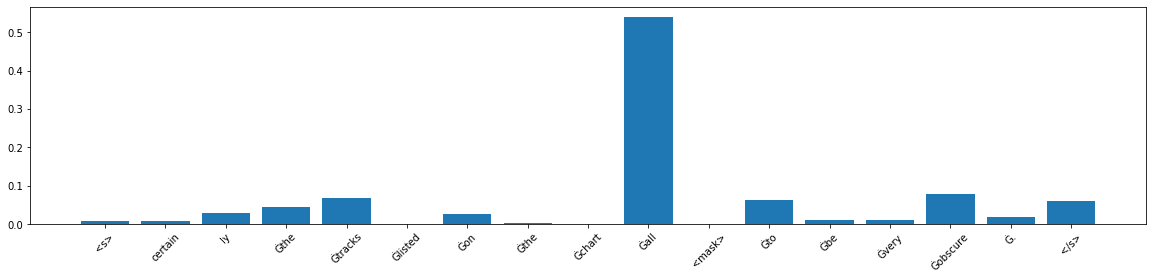

In [25]:
model_wrapped = ModelWrapper(model)
prediction_scores, hidden_states, attentions, contributions_data = model_wrapped(pt_batch)
probs = torch.nn.functional.softmax(prediction_scores, dim=-1)
actual_verb_score = probs[0][target_idx][good_verb_id]
inflected_verb_score = probs[0][target_idx][wrong_verb_id]

main_diff_score = actual_verb_score - inflected_verb_score

# Repeating examples and replacing one token at a time with unk
batch_size = 1
max_len = pt_batch['input_ids'][0].size(0)

# Repeat each example 'max_len' times
x = pt_batch['input_ids'].cpu().detach().numpy()
extended_x = np.reshape(np.tile(x[:,None,...], (1, max_len, 1)),(-1,x.shape[-1]))

# Create unk sequences and unk mask
unktoken = tokenizer.encode([tokenizer.mask_token])[1]
unks = unktoken * np.eye(max_len)
unks =  np.tile(unks, (batch_size, 1))

unk_mask =  (unktoken - unks)/unktoken

# Replace one token in each repeatition with unk
extended_x = extended_x * unk_mask + unks

# Get the new output
extended_logits = model_wrapped.get_prediction(torch.tensor(extended_x, dtype=torch.int64,device=device))
# extended_logits = extended_predictions[0]
extended_probs = torch.nn.Softmax(dim=-1)(extended_logits)
print(extended_probs.size())
extended_correct_probs = extended_probs[:,target_idx,good_verb_id]
print(extended_correct_probs.size())
# extended_wrong_probs =  extended_probs[:,target_idx,wrong_verb_id]
# extended_diff_scores = extended_correct_probs - extended_wrong_probs


# # Save the difference in the probability predicted for the correct class
#diffs = abs(main_diff_score - extended_diff_scores)
diffs = abs(actual_verb_score - extended_correct_probs)

plot_histogram(diffs,tokenized_text)

### Getting attention weights, attention vector norms and contributions from ALTI method

In [26]:
_attentions = [att.detach().cpu().numpy() for att in attentions]
attentions_mat = np.asarray(_attentions)[:,0] # (num_layers,num_heads,src_len,src_len)
att_mat_sum_heads = attentions_mat.sum(axis=1)/attentions_mat.shape[1]
print(att_mat_sum_heads.shape)
normalized_model_norms = normalize_contributions(contributions_data['transformed_vectors_norm'],scaling='sum_one')
resultant_norm = resultants_norm = torch.norm(torch.squeeze(contributions_data['resultants']),p=1,dim=-1)
normalized_contributions = normalize_contributions(contributions_data['contributions'],scaling='min_sum',resultant_norm=resultant_norm)#min_sum


(12, 17, 17)


### Rollout with attention weights (Abnar and Zuidema., 2020)

In [27]:
joint_attentions = compute_rollout(att_mat_sum_heads)

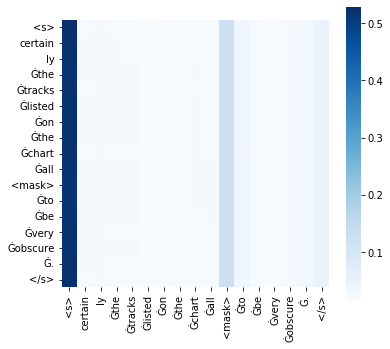

In [28]:
layer = -1
plt.figure(figsize=(6,6))
df = pd.DataFrame(joint_attentions[layer].cpu().detach().numpy(),columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Blues",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

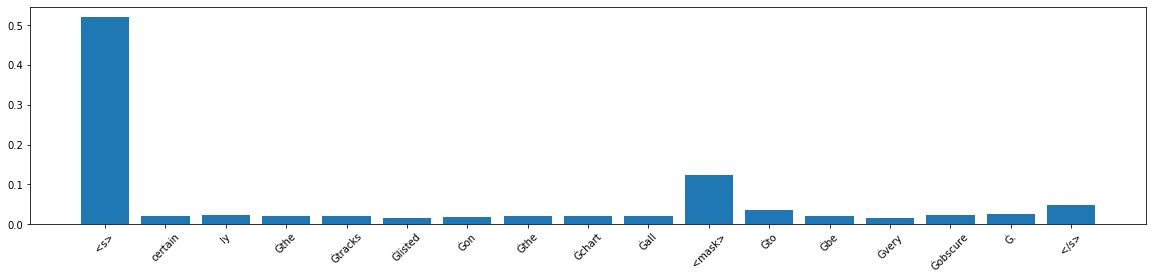

In [29]:
joint_attention_layer = -1
pos = target_idx
joint_attentions_mask = joint_attentions[joint_attention_layer][pos]
plot_histogram(joint_attentions_mask,tokenized_text)

### Attention rollout + |T(x_j)| (Kobayashi et al., 2021)

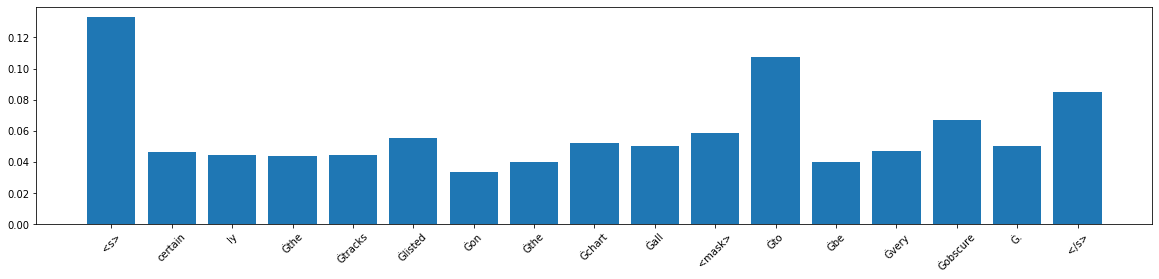

In [30]:
norms_mix = compute_joint_attention(normalized_model_norms)
joint_attention_layer = -1
pos = target_idx
norms_mix_mask = norms_mix[joint_attention_layer][pos]
plot_histogram(norms_mix_mask,tokenized_text)

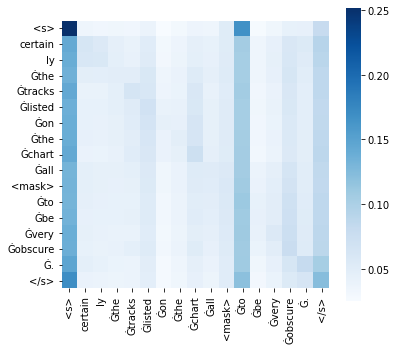

In [31]:
norms_mix = norms_mix.detach().cpu().numpy()
plt.figure(figsize=(6,6))
joint_attention_layer = -1
df = pd.DataFrame(norms_mix[joint_attention_layer],columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Blues",square=True)
plt.gcf().subplots_adjust(bottom=0.2)


### ALTI

torch.float32


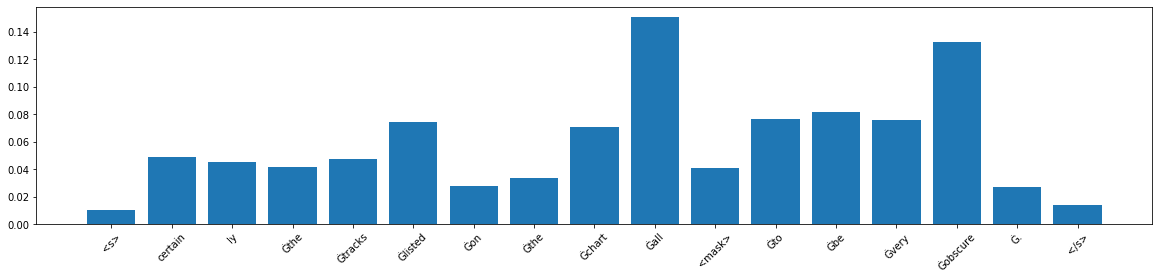

In [32]:
print(normalized_contributions.dtype)
contributions_mix = compute_joint_attention(normalized_contributions)
joint_attention_layer = -1
pos = target_idx
contributions_mix_mask = contributions_mix[joint_attention_layer][pos]
plot_histogram(contributions_mix_mask,tokenized_text)

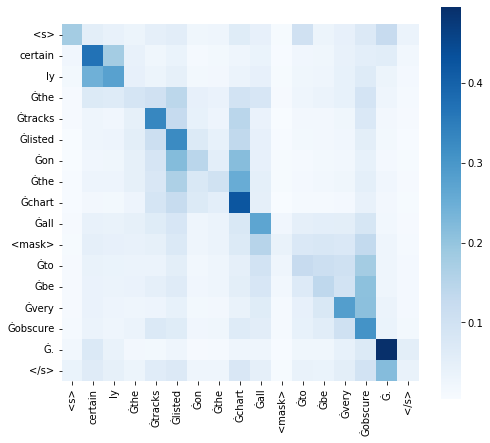

In [33]:
contributions_mix = contributions_mix.detach().cpu().numpy()
plt.figure(figsize=(8,8))

#joint_attention_normalized_layer = contributions_mix[joint_attention_layer] / joint_attentions[joint_attention_layer].sum(axis=-1)[...,None]
df = pd.DataFrame(contributions_mix[joint_attention_layer],columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Blues",square=True)#Reds,,center=0
plt.gcf().subplots_adjust(bottom=0.2)


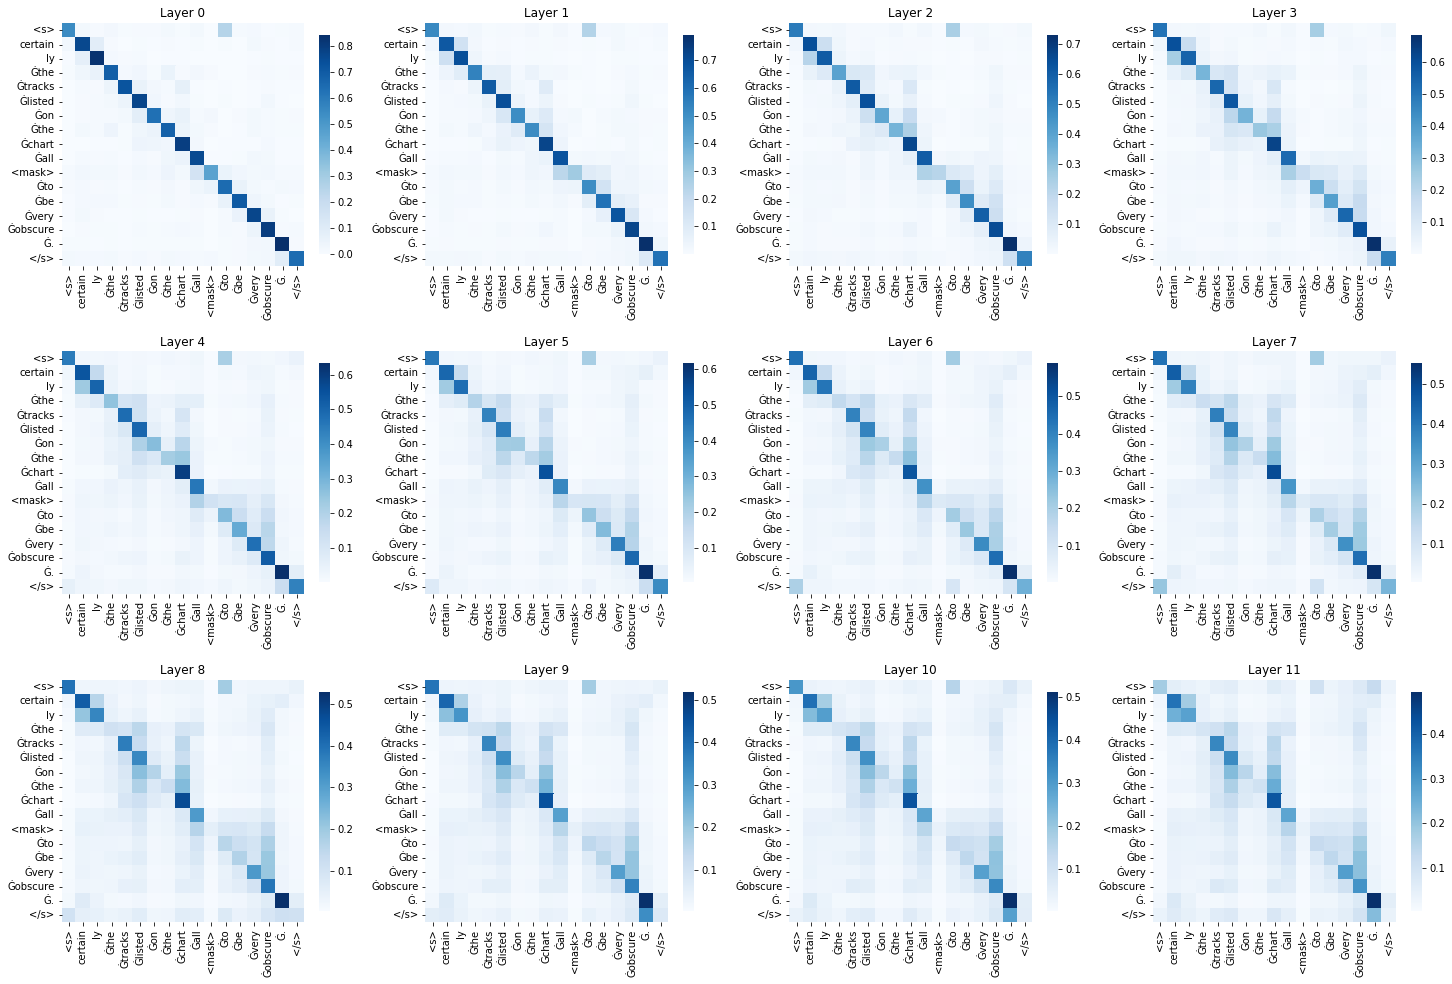

In [34]:
try:
    num_layers = model.config.num_hidden_layers
except:
    num_layers = model.config.n_layers

if num_layers == 12:
    fig, axs = plt.subplots(3, 4,figsize=(25,19),sharey=False)
    row = 4
    col = 4
elif num_layers == 6:
    fig, axs = plt.subplots(2, 3,figsize=(20,13),sharey=False)
    row = 3
    col = 3

for layer in range(0,num_layers):
    df = pd.DataFrame(contributions_mix[layer],columns=tokenized_text,index=tokenized_text)
    sns.heatmap(df,cmap="Blues",square=True,ax=axs[int(layer/row),layer%col],cbar_kws={'shrink': 0.8})
    axs[int(layer/row),layer%col].set_title('Layer ' + str(layer))
    axs[int(layer/row),layer%col].tick_params(axis='x', rotation=90)
    plt.gcf().subplots_adjust(bottom=0.2)

## Other attribution methods with Captum

In [35]:
bert_model_wrapper = LMModelWrapperCaptum(model)

grad_attributions = interpret_sentence_sv(bert_model_wrapper, tokenizer, sentence=text, method='grad', mask_pos=target_idx, label=pred_ind)
grad_input_attributions = interpret_sentence_sv(bert_model_wrapper, tokenizer, sentence=text, method='grad_input', mask_pos=target_idx, label=pred_ind)
grad_ig_attributions = interpret_sentence_sv(bert_model_wrapper, tokenizer, sentence=text, method='ig', mask_pos=target_idx, label=pred_ind)


In [36]:
# accumalate samples in this array for visualization purposes
vis_data_records_ig = []

def add_attributions_to_visualizer(attributions, tokens, label, vis_data_records):
    pred = 1
    attributions_min_max = normalize_attribution_visualization(attributions)
    attributions_min_max = attributions_min_max.cpu().detach().numpy()

    
    # storing couple samples in an array for visualization purposes
    vis_data_records.append(visualization.VisualizationDataRecord(
                            attributions_min_max,
                            pred,
                            label,
                            label,
                            "label",
                            attributions_min_max.sum(),       
                            tokens[:len(attributions_min_max)],
                            0))
    return attributions_min_max

tokens = tokenizer.convert_ids_to_tokens(pt_batch["input_ids"][0].cpu().detach().numpy().tolist())
min_max_grad_attributions = add_attributions_to_visualizer(grad_attributions, tokens, pred_ind, vis_data_records_ig)
min_max_grad_input_attributions = add_attributions_to_visualizer(grad_input_attributions, tokens, pred_ind, vis_data_records_ig)
min_max_grad_ig_attributions = add_attributions_to_visualizer(grad_ig_attributions, tokens, pred_ind, vis_data_records_ig)
min_max_joint_attention_rollout_mask = add_attributions_to_visualizer(joint_attentions_mask, tokens, pred_ind, vis_data_records_ig)
min_max_norm_rollout_mask = add_attributions_to_visualizer(norms_mix_mask, tokens, pred_ind, vis_data_records_ig)
blankout_mask = add_attributions_to_visualizer(diffs, tokens, pred_ind, vis_data_records_ig)
min_max_contributions_mix_mask = add_attributions_to_visualizer(contributions_mix_mask, tokens, pred_ind, vis_data_records_ig)
visualization.visualize_text(vis_data_records_ig);

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
2045,2045 (1.00),label,6.06,#s certain ly Ġthe Ġtracks Ġlisted Ġon Ġthe Ġchart Ġall #mask Ġto Ġbe Ġvery Ġobscure Ġ. #/s
2045,2045 (1.00),label,5.65,#s certain ly Ġthe Ġtracks Ġlisted Ġon Ġthe Ġchart Ġall #mask Ġto Ġbe Ġvery Ġobscure Ġ. #/s
2045,2045 (1.00),label,5.44,#s certain ly Ġthe Ġtracks Ġlisted Ġon Ġthe Ġchart Ġall #mask Ġto Ġbe Ġvery Ġobscure Ġ. #/s
2045,2045 (1.00),label,1.44,#s certain ly Ġthe Ġtracks Ġlisted Ġon Ġthe Ġchart Ġall #mask Ġto Ġbe Ġvery Ġobscure Ġ. #/s
2045,2045 (1.00),label,4.30,#s certain ly Ġthe Ġtracks Ġlisted Ġon Ġthe Ġchart Ġall #mask Ġto Ġbe Ġvery Ġobscure Ġ. #/s
2045,2045 (1.00),label,1.81,#s certain ly Ġthe Ġtracks Ġlisted Ġon Ġthe Ġchart Ġall #mask Ġto Ġbe Ġvery Ġobscure Ġ. #/s
2045,2045 (1.00),label,5.89,#s certain ly Ġthe Ġtracks Ġlisted Ġon Ġthe Ġchart Ġall #mask Ġto Ġbe Ġvery Ġobscure Ġ. #/s


## Prepare paper saliency map tables

In [37]:
attributions_list = []
attributions_list.append(min_max_grad_attributions)
attributions_list.append(min_max_grad_input_attributions)
attributions_list.append(min_max_grad_ig_attributions)
attributions_list.append(min_max_joint_attention_rollout_mask)
attributions_list.append(min_max_norm_rollout_mask)
attributions_list.append(blankout_mask)
attributions_list.append(min_max_contributions_mix_mask)
prepare_colorize()
methods_list = [0,1,2,5,6]
methods_dict = {0:'$\\text{Grad}_{l2}$', 1:'Grad $\\cdot$ input', 2:'Integrated Gradients', 3:'Attn Rollout', 4:'Norm Rollout', 5: 'Blank-out', 6:'ALTI'}
figure_saliency(attributions_list, tokenized_text,methods_list,methods_dict)

## Correlation between methods

In [3]:
!python correlations.py distilbert sva 500

Loading distilbert ...
Loading sva ...
